In [ ]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import random
from dataset import *
import gc
from model import *

In [ ]:
class Args:
    def __init__(self):
        # System configs
        self.gpu = 3
        self.run_label = 0
        self.verbose = False
        self.log_root = '/data/hdim-forecast/log5/forecast'
        
        # Global model choice parameters
        self.x_dim = 2         # Number of input features 
        self.y_dim = 131       # Number of predicted values
        self.n_past = 32       # Number of steps from the past to condition on
        self.n_future = 10     # Number of steps into the future to predict
        self.feat_size = 131   # Number of basis features
        self.lstm_hidden_dim = 256  
        self.lstm_layers = 2
        self.lstm_dropout = 0.5
        self.prediction_model = 'lstm'        
        
        # Parameters only used for forecasting
        self.f_learning_rate = 1e-2   # learning rate for optimizing queries
        self.f_batch_size = 8    # batch size to evaluate each query on 
        self.n_sample = 1024   # Number of samples to simulate
        
        # Parameters only used for sampler training
        self.s_test_len = 1024   # The length of test sequence to visualize
        self.s_learning_rate = 1e-4  
        self.s_batch_size = 8
        
        # Parameters only used for predictor training
        self.p_learning_rate = 1e-4
        self.p_batch_size = 32
        
args = Args()
device = torch.device('cuda:%d' % args.gpu)
args.device = device

In [ ]:
while True:
    args.name = '%s-%d-%d-%d-%d-%d-%d-%d-%.1f-%.4f-%d' % \
        (args.prediction_model, args.x_dim, args.y_dim, args.n_past, args.n_future, args.feat_size, 
         args.lstm_layers, args.lstm_hidden_dim, args.lstm_dropout, args.f_learning_rate, args.run_label)
    args.log_dir = os.path.join(args.log_root, args.name)
    if not os.path.isdir(args.log_dir):
        os.makedirs(args.log_dir)
        break
    args.run_label += 1
print("Run number = %d" % args.run_label)
writer = SummaryWriter(args.log_dir)
log_writer = open(os.path.join(args.log_dir, 'results.txt'), 'w')

start_time = time.time()
global_iteration = 0
random.seed(args.run_label)  # Set a different random seed for different run labels
torch.manual_seed(args.run_label)
    
def log_scalar(name, value, epoch):
    writer.add_scalar(name, value, epoch)
    log_writer.write('%f ' % value)
    
def message(epoch):
    print("Finished epoch %d, time elapsed %.1f" % (epoch, time.time() - start_time))

In [ ]:
train_dataset = TrafficDataset(train=True, max_len=args.n_past+args.n_future)
train_loader = DataLoader(train_dataset, batch_size=args.f_batch_size, shuffle=True, num_workers=4)

test_dataset = TrafficDataset(train=False, max_len=args.n_past+args.n_future)
test_loader = DataLoader(test_dataset, batch_size=args.f_batch_size, shuffle=False, num_workers=4)

In [ ]:
feat_model = FeatureNetFirstMoment(args.feat_size)

In [ ]:
args.sample_name = '%s-%d-%d-%d-%d-%d-%d-%d-%.1f-%.4f-4' % \
        (args.prediction_model, args.x_dim, args.y_dim, args.n_past, args.n_future, args.feat_size, 
         args.lstm_layers, args.lstm_hidden_dim, args.lstm_dropout, args.s_learning_rate)
    
sampler = LSTMSampler(args)
sampler.load_state_dict(torch.load('pretrained/sampler_traffic_%s.pt' % args.sample_name))
sampler = sampler.eval().to(device)

In [ ]:
args.predictor_name = '%s-%d-%d-%d-%d-%d-%d-%d-%.1f-%.4f-2' % \
        (args.prediction_model, args.x_dim, args.y_dim, args.n_past, args.n_future, args.feat_size, 
         args.lstm_layers, args.lstm_hidden_dim, args.lstm_dropout, args.p_learning_rate)
predictor = PredictorRecurrent(args)
predictor.load_state_dict(torch.load('pretrained/predictor_traffic_%s.pt' % args.predictor_name))
predictor = predictor.eval().to(device)
#             x: ([batch_size, n_past, x_dim]), the input feature
 #            y: ([batch_size, n_past, y_dim]), the previous step label

In [ ]:
# Design a set of query functions, each query function should be a map from [batch_size, 1, 64, 64] tensor into a real number

def get_query_travel():
    num_route = torch.randint(low=3, high=10, size=(1,))
    routes = torch.randperm(args.y_dim, device=args.device)[:num_route]
    def query_func(y):   # Each query_func take as input y of size [batch_size, y_dim]
        return y[:, routes].sum(dim=1)
    return query_func

def get_query_travel_sqr():
    num_route = torch.randint(low=3, high=10, size=(1,))
    routes = torch.randperm(args.y_dim, device=args.device)[:num_route]
    def query_func(y):   # Each query_func take as input y of size [batch_size, y_dim]
        return y[:, routes].sum(dim=1).pow(2)
    return query_func

def get_query_travel_thresh():
    num_route = torch.randint(low=3, high=10, size=(1,))
    routes = torch.randperm(args.y_dim, device=args.device)[:num_route]
    def query_func(y):   # Each query_func take as input y of size [batch_size, y_dim]
        return (y[:, routes].sum(dim=1) > 9).type(torch.float32)
    return query_func


queries_all = [get_query_travel_thresh() for i in range(10)]


In [ ]:
bx, by = iter(test_loader).next()
bx, by = bx.to(device).permute(1, 0, 2), by.to(device).permute(1, 0, 2)
with torch.no_grad():
    plt.figure(figsize=(15, 15))
    # bx_expanded = torch.cat([bx[0, :32], next_time(bx[0, -1, 1], 500)])
    for i in range(16):
        plt.subplot(4, 4, i+1)
        samples = sampler.sample(bx, by[:args.n_past], args.n_future).permute(1, 0, 2)
        plt.plot(torch.cat([by[0, :, 0], samples[0, :, 0]]).cpu())
    plt.show()

In [ ]:
print(predictor(bx[:, :args.n_past], by[:, :args.n_past]).shape)

In [ ]:
mb_size = 16
assert args.n_sample % mb_size == 0
err_sim = []
err_combo = []
err_feat = []

arr_sim, arr_pred, arr_pred_true, arr_residue, arr_residue_true, arr_exp_true = [], [], [], [], [], []

for idx, data in enumerate(test_loader):
    bx, by = data[0].to(device), data[1].to(device)

    # print(bx.shape)
    with torch.no_grad():
        # Run the simulation over multiple batches to avoid memory overflow
        sim_bx = torch.zeros(args.n_sample, args.f_batch_size, args.y_dim).to(device)
        sim_feat = torch.zeros(args.n_sample, args.f_batch_size, args.feat_size).to(device)
        
        input_raw = by[:, -1, :].clone()
        input_raw[input_raw <= 0.1] = float('nan')
        true_feat = feat_model(input_raw)
        for rep in range(args.n_sample):
            by_in = by[:, :args.n_past, :].to(device)
            # print(by_in.shape)
            # print(bx_in.shape)
            sim_bx[rep] = sampler.sample(bx.permute(1, 0, 2), by_in.permute(1, 0, 2), args.n_future)[-1]
            # print(sim_bx.shape)
            # print(simulated_bx.shape)
        for rep in range(args.n_sample // mb_size):
            sim_feat[rep*mb_size:(rep+1)*mb_size] = feat_model(sim_bx[rep*mb_size:(rep+1)*mb_size].view(-1, args.y_dim)).view(mb_size, args.f_batch_size, args.feat_size)

    for q_index, query in enumerate(queries_all):
        alpha = torch.randn([1, args.f_batch_size, args.feat_size], requires_grad=True, device=device)
        alpha_optim = optim.Adam([alpha], lr=args.f_learning_rate)

        sim_val = query(sim_bx.reshape(-1, args.y_dim)).view(args.n_sample, args.f_batch_size)
        # print(sim_val)
        for qiter in range(5000):
            alpha_optim.zero_grad()
            loss_q = (sim_val - (sim_feat * alpha).mean(dim=2)).abs().mean()
            # print(loss_q, alpha)
            # print(query(bx[:, 10]))
            # print((feat_model(bx[:, 10]) * alpha).mean(dim=1))
            loss_q.backward()
            alpha_optim.step()
            writer.add_scalar('loss_q_%d' % q_index, loss_q, qiter)
        
        # Compute the expectation if we were to use the simulated data only
        with torch.no_grad():
            true_exp = query(input_raw)
            # print(true_exp)
            valid_idx = ~torch.isnan(true_exp)
            true_exp = true_exp[valid_idx]
            if valid_idx.sum() == 0:
                continue
            # Expectation according to future simulations
            sim_exp = sim_val.mean(dim=0)[valid_idx]
            
            # print(sim_exp)
            # print(sim_exp.shape)
            # Expectation of the features
            # print(predictor(bx[0, :, 0:2]).shape)
            pred_exp_feat = (predictor(bx[:, :args.n_past], by[:, :args.n_past]) * alpha[0]).mean(dim=1)[valid_idx]
            # print(pred_exp_feat)
            residue_exp = (sim_val - (sim_feat * alpha).mean(dim=2)).mean(dim=0)[valid_idx]
            combo_exp = pred_exp_feat + residue_exp


            
            true_exp_feat = (true_feat.mean(dim=0) * alpha[0]).mean(dim=1)[valid_idx]
            true_exp_residue = true_exp - true_exp_feat 
            
            err_sim.append(sim_exp - true_exp)
            err_combo.append(combo_exp - true_exp)
            err_feat.append(pred_exp_feat - true_exp_feat)
            
            arr_residue.append(residue_exp)
            arr_pred.append(pred_exp_feat)
            arr_sim.append(sim_exp)
            arr_pred_true.append(true_exp_feat)
            arr_residue_true.append(true_exp_residue)
            arr_exp_true.append(true_exp)
    message(idx)
    global_iteration += 1
    # break


In [ ]:
print(true_feat.shape)

In [ ]:
err_sim = torch.cat(err_sim).cpu().numpy()
err_combo = torch.cat(err_combo).cpu().numpy()
err_feat = torch.cat(err_feat).cpu().numpy()

In [ ]:
arr_residue = torch.cat(arr_residue).cpu().numpy()
arr_pred = torch.cat(arr_pred).cpu().numpy()
arr_pred_true = torch.cat(arr_pred_true).cpu().numpy()
arr_sim = torch.cat(arr_sim).cpu().numpy()
arr_residue_true = torch.cat(arr_residue_true).cpu().numpy()
arr_exp_true = torch.cat(arr_exp_true).cpu().numpy()

In [30]:
arr_combo_clipped = (arr_pred + arr_residue).clip(0, 1)

In [33]:
print(np.mean(np.square(err_sim)), np.mean(np.square(arr_combo_clipped - arr_exp_true)))
print(np.mean(np.abs(err_sim)), np.mean(np.abs(err_combo)))

0.35050574 0.38502246
0.4280135 0.46620408


In [ ]:
err_combo_alt = (arr_residue_true - arr_residue) + (arr_pred_true - arr_pred) 
err_pred = (arr_pred_true + arr_residue_true) - arr_pred

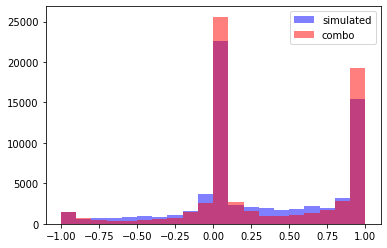

In [31]:
# plt.xlim([-100, 100])
plt.hist(err_sim, bins=20, alpha=0.5, color='b', label='simulated')
plt.hist(arr_combo_clipped - arr_exp_true, bins=20, alpha=0.5, color='r', label='combo')
# plt.hist(err_feat, bins=40, color='g', alpha=0.5, label='pred')
# plt.hist(err_combo_alt, bins=40, alpha=0.5, color='g', label='')

plt.legend()
plt.show()

In [ ]:
# plt.hist(arr_residue.cpu().numpy(), bins=20, alpha=0.5)
plt.hist(arr_pred, bins=40, alpha=0.5, color='r')
# plt.hist(arr_pred_true, bins=40, alpha=0.5, color='g')
# plt.hist(arr_pred - arr_pred_true, bins=40, alpha=0.5, color='b')
plt.hist(arr_residue, bins=40, alpha=0.5, color='m')
# plt.hist(arr_exp_true, bins=40, alpha=0.5, color='c')
plt.show()